# Prolific Study Evaluation
This notebook loads and processes the raw data collected on Supabase from the online human study done via Prolific.
It reconstructs participant-level and trial-level responses from the stored jsPsych logs,
and prepares clean analysis tables for downstream statistical evaluation.

In [144]:
import os
from dotenv import load_dotenv
from supabase import create_client
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
from scipy import stats
import numpy as np

load_dotenv()

SUPABASE_URL = "https://utwhgfveotpusdjopcnl.supabase.co"
SUPABASE_KEY = os.environ["SUPABASE_SERVICE_ROLE"]

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

In [145]:
# Read out results table and print as dataframe
response = supabase.table("results").select("*").execute()

rows = response.data
df_raw = pd.DataFrame(rows)

# Drop all test and debug participants
df_raw = df_raw[(~df_raw['prolific_pid'].str.startswith('DEBUG')) &
    (~df_raw['prolific_pid'].str.startswith('TEST_'))
].copy()

display(df_raw)
print(df_raw.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
55,9c0d06ee-31ab-4c79-9f29-60340eb12bc2,5997043dbbe84800017964a7,profile_6_last,failed_distractor,2026-01-28T12:57:10.075912+00:00,"[{'rt': 11700, 'study_id': '6962232f30c21461e6...",1769605029862,1769604712731,67
56,cae0bb77-d57a-41ca-8dd0-f86f78a6d8da,5a381de00006450001bf2691,profile_17_last,completed,2026-01-28T13:01:09.976787+00:00,"[{'rt': 14626, 'study_id': '6962232f30c21461e6...",1769605269189,1769604706487,17
57,5234326d-6ea1-49fb-93af-ee75e3984bec,676061b0d6e01e2e9548a4b9,profile_23_last,completed,2026-01-28T13:01:43.657952+00:00,"[{'rt': 21763, 'study_id': '6962232f30c21461e6...",1769605302694,1769604839827,31
58,da575643-83eb-4e38-80ce-03c10cd672cd,5bf8a27021a4e1000194fc76,profile_2_last,completed,2026-01-28T13:06:27.084044+00:00,"[{'rt': 14676, 'study_id': '6962232f30c21461e6...",1769605586286,1769605024569,45
59,22802372-74d0-411e-b879-ad9fdd2cf510,6146548679f86b7cb069e7f7,profile_11_last,completed,2026-01-28T13:07:56.910077+00:00,"[{'rt': 17468, 'study_id': '6962232f30c21461e6...",1769605676363,1769604826317,5
60,8d8195d4-b457-4dc8-8759-55a0fd0bdd29,5c5cad3e4ee81200018eafe2,profile_33_last,completed,2026-01-28T13:08:39.759393+00:00,"[{'rt': 12588, 'study_id': '6962232f30c21461e6...",1769605719886,1769604862872,53
61,1a28d289-0ebb-4d80-8695-5706704a0021,6053e01a6a8e8516ba7d47a7,profile_3_first,completed,2026-01-28T13:11:20.176687+00:00,"[{'rt': 17185, 'study_id': '6962232f30c21461e6...",1769605879714,1769604911837,60
62,af0da243-8692-4325-8db2-4342e07029c7,571bdaa76b0894001362f780,profile_7_first,completed,2026-01-28T13:15:48.124049+00:00,"[{'rt': 1575, 'study_id': '6962232f30c21461e6a...",1769606146541,1769605546811,68
63,6950a956-3a7a-4d54-ada1-1895374aa902,676063838d4db0d3eaa69c2b,profile_13_last,completed,2026-01-28T13:17:42.084933+00:00,"[{'rt': 1414, 'study_id': '6962232f30c21461e6a...",1769606181795,1769605539794,9
64,7c24ad90-a9d6-44d4-80d1-ea16478e0096,61517db6a7589569521b2356,profile_35_first,failed_attention,2026-01-28T13:24:27.069578+00:00,"[{'rt': 28624, 'study_id': '6962232f30c21461e6...",1769606665652,1769605461409,56


(12, 9)


In [181]:
df.question_order.notna().sum()

np.int64(45)

In [168]:
# Explode df_raw into trial-level df 
import pandas as pd

rows = []

for _, row in df_raw.iterrows():
    pid = row["prolific_pid"]
    profile_id = row["profile_id"]
    exit_reason = row["exit_reason"]

    if profile_id.endswith("_first"):
        intro_position = "first"
    elif profile_id.endswith("_last"):
        intro_position = "last"
    else:
        intro_position = None

    for trial in row["data"]:
        flat = {
            "PROLIFIC_PID": pid,
            "profile_id": profile_id,
            "exit_reason": exit_reason,
            "intro_position": intro_position,
        }
        flat.update(trial)
        rows.append(flat)

df = pd.DataFrame(rows)

display(df.head(10))
print("Shape:", df.shape)


,PROLIFIC_PID,profile_id,exit_reason,intro_position,rt,study_id,exit_time,timed_out,session_id,subject_id,...,variant_region,percent_colored,passed,response,sanity_id,question_order,response_index,correct_response,stimulus,slider_start
0,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,11700.0,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,4725.0,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,NaN,NaN,True,{'Q0': 4},1.0,[0],4.0,Strongly Disagree,NaN,NaN
6,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1189, 37)


In [147]:
print("Task type counts:")
print(df["task_type"].value_counts())
print("\nExit reason counts:")
print(df_raw["exit_reason"].value_counts(dropna=False))

Task type counts:
task_type
color_judgment    1106
sanity              57
introspection       11
warning              3
Name: count, dtype: int64

Exit reason counts:
exit_reason
completed            10
failed_distractor     1
failed_attention      1
Name: count, dtype: int64


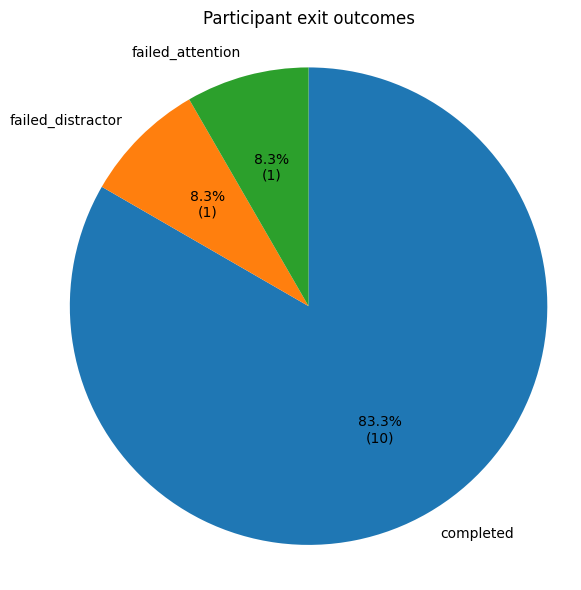

In [148]:
# Dropouts vs completions
exit_counts = df_raw['exit_reason'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    exit_counts,
    labels=exit_counts.index,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100 * exit_counts.sum()))})",
    startangle=90,
    counterclock=False,
)
plt.title("Participant exit outcomes")
plt.axis("equal")
plt.tight_layout()
plt.show()

## Failed by distractor colors

In [149]:
# Inpect failed distractor trials
df_failed = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "failed_distractor") &
    (df["target_color"] != df["response_label"]) &
    (df["PROLIFIC_PID"] == "TEST_1") &
    (df["response_label"] != "white")
].copy()

print(f"Number of failed trials: {len(df_failed)}")
display(df_failed[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_failed.iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

Number of failed trials: 0


,PROLIFIC_PID,object,variant_region,percent_colored,target_color,response_label,image_path


## Succesfull completions

In [150]:
# Extract only valid color judgments for analysis)
df_complete = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "completed")
].copy()

len(df_complete)

1000

In [151]:
df_complete = df[df["task_type"] == "color_judgment"].copy()

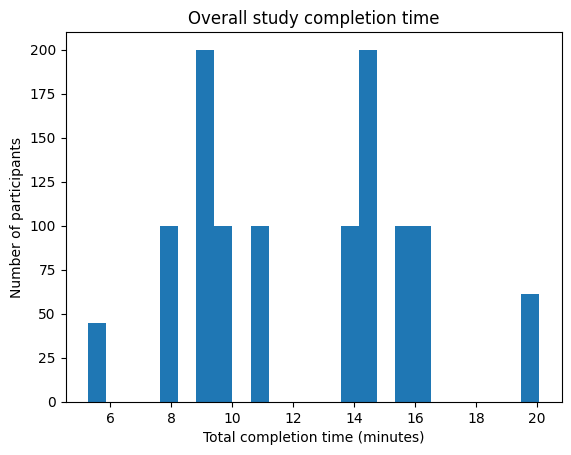

In [152]:
# Participant-level completion time (minutes) 
df_complete['experiment_start_time'] = pd.to_datetime(
    df_complete['experiment_start_time'], unit='ms'
)
df_complete['exit_time'] = pd.to_datetime(
    df_complete['exit_time'], unit='ms'
)

df_complete['total_time_min'] = (
    df_complete['exit_time'] - df_complete['experiment_start_time']
).dt.total_seconds() / 60

# Plot
plt.figure()
plt.hist(df_complete['total_time_min'], bins=25)
plt.xlabel('Total completion time (minutes)')
plt.ylabel('Number of participants')
plt.title('Overall study completion time')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Accuracy vs. coloring fraction

In [153]:
# Accuracy: response must match target_color
df_complete.loc[df_complete["variant_region"] == "BG", "target_color"] = "white" # Fix wrong labels for BG, will be fixed in future study runs
df_complete["accuracy"] = (df_complete["response_label"] == df_complete["target_color"]).astype(float)
df_complete["accuracy"].mean()

np.float64(0.810126582278481)

In [154]:
grouped = df_complete.groupby(["variant_region", "percent_colored"])

summary = grouped["accuracy"].agg(
    mean="mean",
    std="std",
    n="count"
).reset_index()

# Optional: 95% CI
summary["ci"] = (
    stats.t.ppf(0.975, summary["n"] - 1)
    * (summary["std"] / np.sqrt(summary["n"]))
)


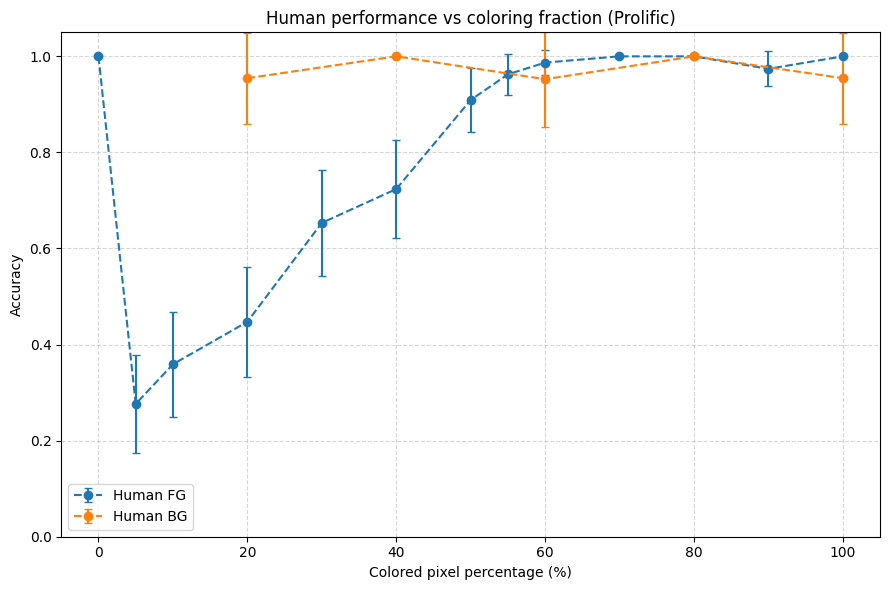

In [155]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

for region in ["FG", "BG"]:
    sub = summary[summary["variant_region"] == region]
    if sub.empty:
        continue

    ax.errorbar(
        sub["percent_colored"],
        sub["mean"],
        yerr=sub["ci"],
        fmt="o--",
        color=colors[region],
        capsize=3,
        label=f"Human {region}",
    )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.05)
ax.set_title("Human performance vs coloring fraction (Prolific)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


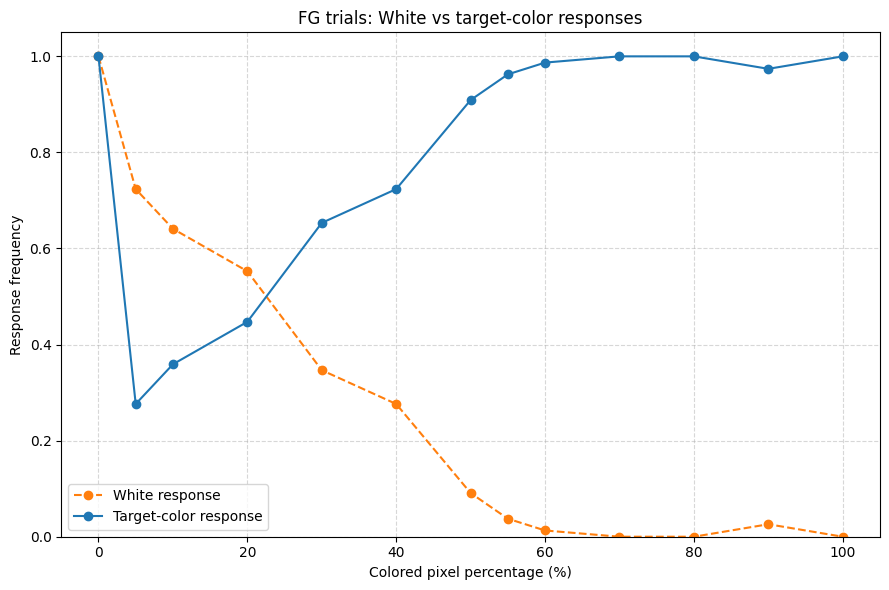

In [156]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

fg_summary = (
    df_fg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_target=("is_target", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_white"],
    "o--",
    label="White response",
    color="#ff7f0e",
)

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_target"],
    "o-",
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

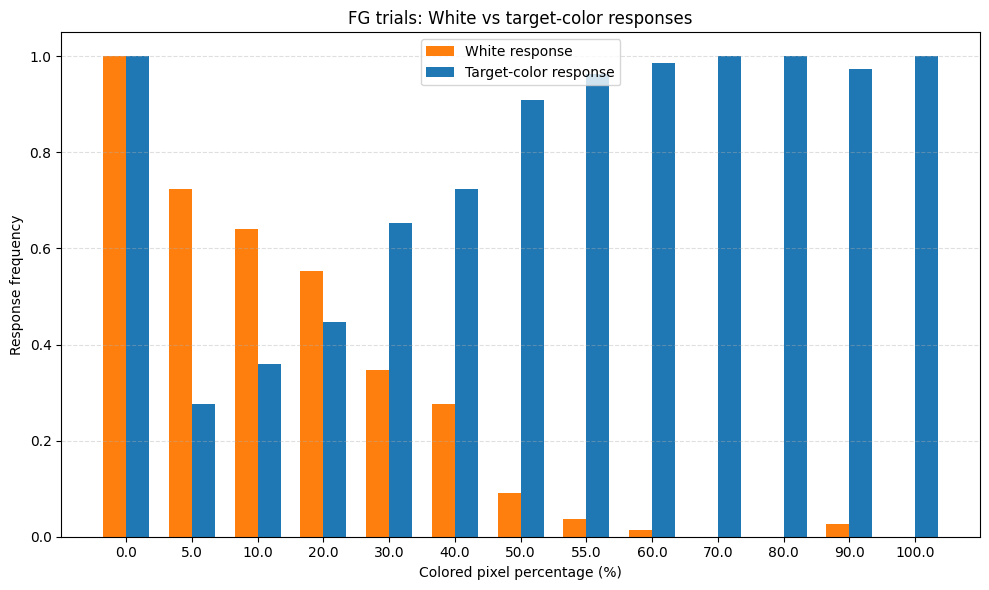

In [157]:
x = np.arange(len(fg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    fg_summary["p_white"],
    width,
    label="White response",
    color="#ff7f0e",
)

ax.bar(
    x + width / 2,
    fg_summary["p_target"],
    width,
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xticks(x)
ax.set_xticklabels(fg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


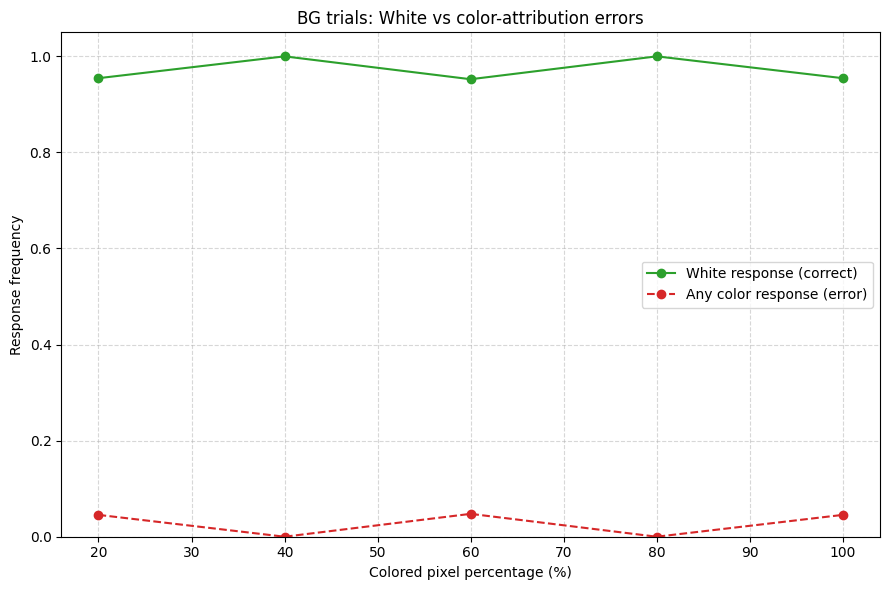

In [158]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

bg_summary = (
    df_bg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_colored=("is_colored", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_white"],
    "o-",
    label="White response (correct)",
    color="#2ca02c",
)

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_colored"],
    "o--",
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

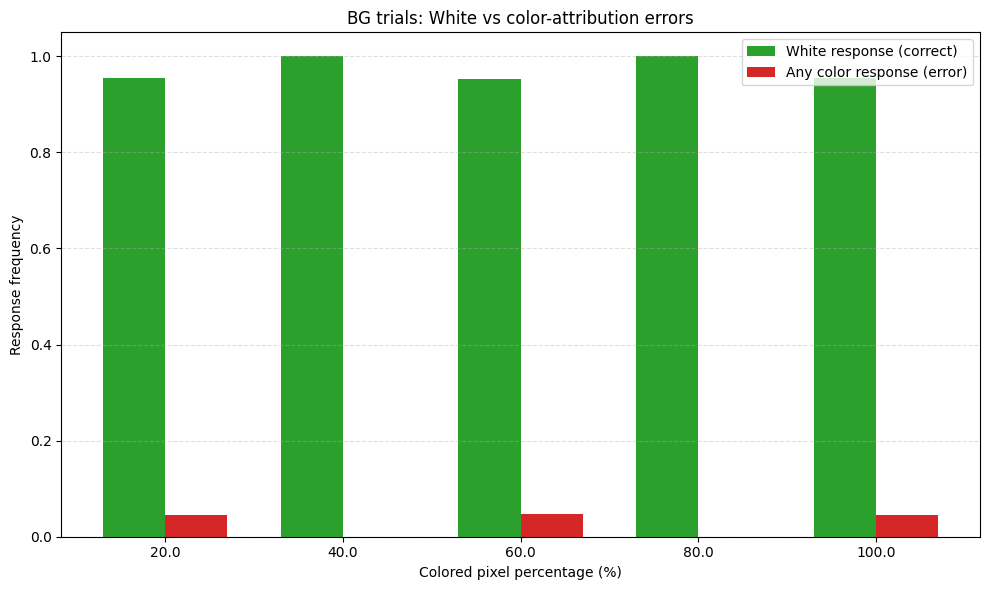

In [159]:
x = np.arange(len(bg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    bg_summary["p_white"],
    width,
    label="White response (correct)",
    color="#2ca02c",
)

ax.bar(
    x + width / 2,
    bg_summary["p_colored"],
    width,
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xticks(x)
ax.set_xticklabels(bg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

### Certainty vs. coloring fraction

In [160]:
df_complete["certainty"].mean()

np.float64(8.375226039783001)

In [161]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["certainty"] = pd.to_numeric(df_cert["certainty"], errors="coerce")

grouped = df_cert.groupby(["variant_region", "percent_colored"])

cert_summary = grouped["certainty"].agg(
    mean="mean",
    std="std",
    n="count"
).reset_index()

# 95% CI (optional)
cert_summary["ci"] = (
    stats.t.ppf(0.975, cert_summary["n"] - 1)
    * (cert_summary["std"] / np.sqrt(cert_summary["n"]))
)

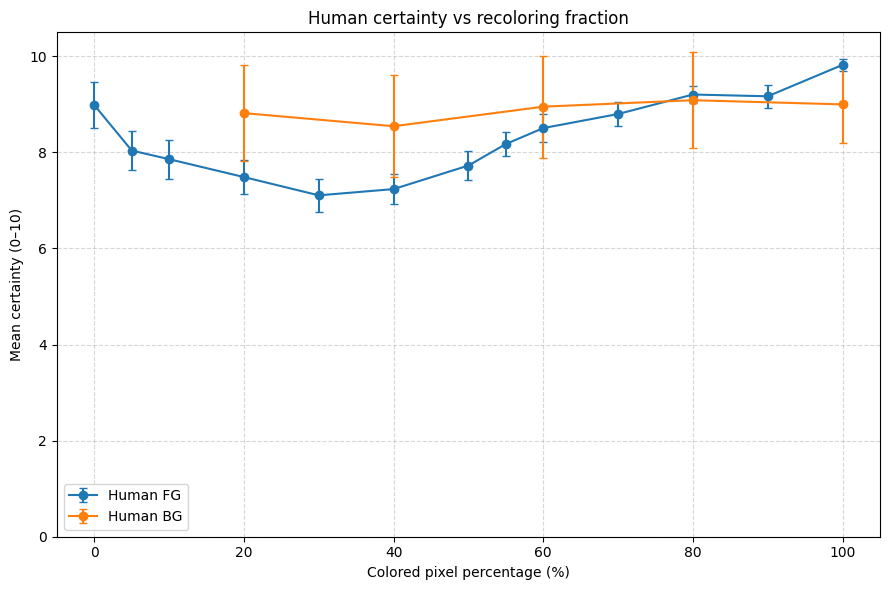

In [162]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

for region in ["FG", "BG"]:
    sub = cert_summary[cert_summary["variant_region"] == region]
    if sub.empty:
        continue

    ax.errorbar(
        sub["percent_colored"],
        sub["mean"],
        yerr=sub["ci"],
        fmt="o-",
        color=colors[region],
        capsize=3,
        label=f"Human {region}",
    )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Mean certainty (0–10)")
ax.set_ylim(0, 10.5)
ax.set_title("Human certainty vs recoloring fraction")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

## Response times

In [163]:
df_rt = df_complete.copy()

# ms → seconds
df_rt["color_time"] = df_rt["color_time"] / 1000

# keep valid RTs only
df_color_rt = df_rt[
    df_rt["color_time"].notna() &
    (df_rt["color_time"] > 0)
]

groups = [
    df_color_rt.loc[df_color_rt["variant_region"] == "FG", "color_time"].values,
    df_color_rt.loc[df_color_rt["variant_region"] == "BG", "color_time"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(
    groups,
    tick_labels=["FG", "BG"],
    showfliers=False,
)

plt.xlabel("Variant region")
plt.ylabel("Color decision RT (seconds)")
plt.title("Reaction times for color judgments (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


KeyError: 'color_time'

In [ ]:
df_rt["final_certainty_time"] = df_rt["second_certainty_time"].fillna(
    df_rt["first_certainty_time"]
)

df_rt["rt_certainty_tot_sec"] = (
    (df_rt["final_certainty_time"] - df_rt["color_time"]) / 1000
)

df_rt = df_rt[
    df_rt["rt_certainty_tot_sec"].notna() &
    (df_rt["rt_certainty_tot_sec"] > 0)
]

df_rt["rt_certainty_revision_sec"] = (
    (df_rt["second_certainty_time"] - df_rt["first_certainty_time"]) / 1000
)

df_revision = df_rt[
    df_rt["rt_certainty_revision_sec"].notna() &
    (df_rt["rt_certainty_revision_sec"] > 0)
]

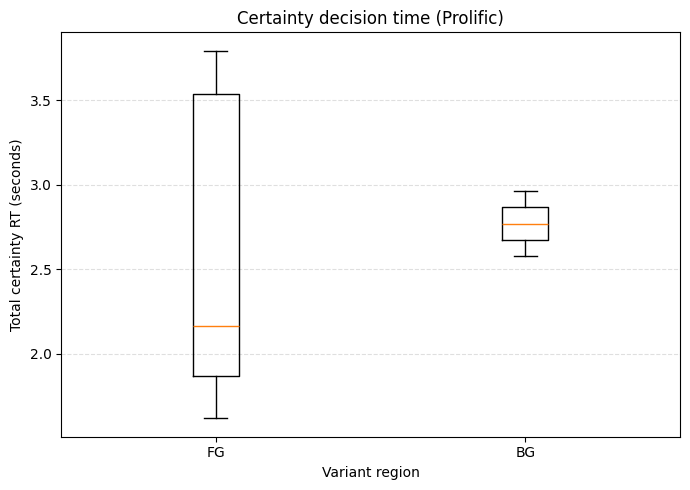

In [ ]:
groups = [
    df_rt[df_rt["variant_region"] == "FG"]["rt_certainty_tot_sec"].values,
    df_rt[df_rt["variant_region"] == "BG"]["rt_certainty_tot_sec"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(groups, tick_labels=["FG", "BG"], showfliers=False)
plt.xlabel("Variant region")
plt.ylabel("Total certainty RT (seconds)")
plt.title("Certainty decision time (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
rev_rate = (
    df_complete["second_certainty_time"].notna()
    .groupby(df_complete["variant_region"])
    .mean()
)

print(rev_rate)


variant_region
BG    0.000000
FG    0.142857
Name: second_certainty_time, dtype: float64


## Introspection question

In [170]:
df[df["task_type"] == "introspection"][["intro_position","response", "slider_start"]]


,intro_position,response,slider_start
156,last,58,50.0
263,last,14,50.0
371,last,80,50.0
478,last,52,50.0
585,last,82,50.0
587,first,62,50.0
695,first,53,50.0
907,last,84,50.0
909,first,83,50.0
1081,last,51,50.0


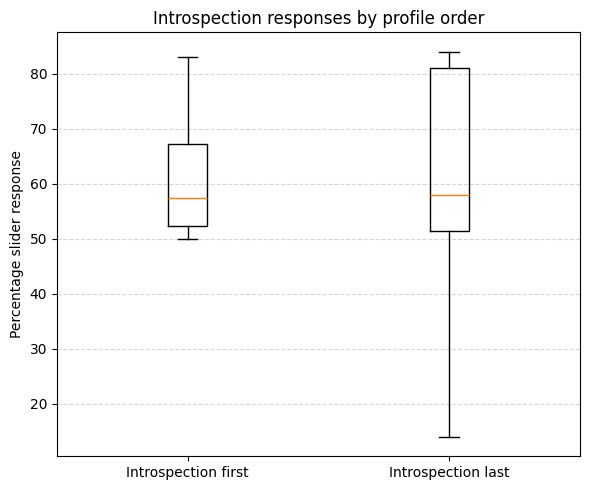

In [175]:
# Keep only introspection trials
df_intro = df[
    (df["task_type"] == "introspection") &
    (df["intro_position"].isin(["first", "last"]))
].copy()

groups = [
    df_intro[df_intro["intro_position"] == "first"]["response"].dropna(),
    df_intro[df_intro["intro_position"] == "last"]["response"].dropna(),
]

plt.figure(figsize=(6, 5))
plt.boxplot(
    groups,
    tick_labels=["Introspection first", "Introspection last"],
    showfliers=True,
)

plt.ylabel("Percentage slider response")
plt.title("Introspection responses by profile order")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Other ideas

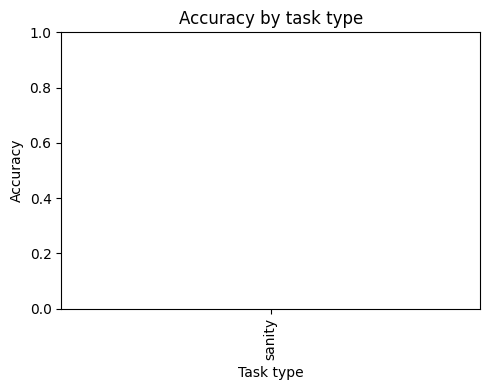

In [ ]:
# Cell 4: Accuracy by task type

df_scored = df[df['is_correct'].notna()].copy()

# Convert True/False -> 1/0
df_scored['is_correct_num'] = df_scored['is_correct'].astype(int)

accuracy_by_task = (
    df_scored
    .groupby('task_type')['is_correct_num']
    .mean()
    .sort_values()
)

plt.figure(figsize=(5, 4))
accuracy_by_task.plot(kind='bar')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Task type')
plt.title('Accuracy by task type')
plt.tight_layout()
plt.show()


In [ ]:
#Color–concept entanglement proxy
# Interesting angle: does accuracy drop when distractor errors increase?

plt.figure()
plt.scatter(df['distractor_errors'], df['is_correct'].astype(int), alpha=0.2)
plt.xlabel('Number of distractor errors')
plt.ylabel('Correct (1=yes, 0=no)')
plt.title('Accuracy vs distractor interference')
plt.show()

#Certainty vs correctness

certainty_stats = (
    df.groupby('is_correct')['certainty']
      .mean()
)

plt.figure()
certainty_stats.plot(kind='bar')
plt.xticks([0, 1], ['Incorrect', 'Correct'], rotation=0)
plt.ylabel('Mean certainty')
plt.title('Metacognition: certainty tracks correctness')
plt.show()

# Learning or fatigue over time

# Order trials within participant

df_sorted = df.sort_values(['PROLIFIC_PID', 'trial_index'])
df_sorted['rolling_accuracy'] = (
    df_sorted.groupby('PROLIFIC_PID')['is_correct']
             .rolling(window=10, min_periods=5)
             .mean()
             .reset_index(level=0, drop=True)
)

plt.figure()
plt.plot(df_sorted['rolling_accuracy'], alpha=0.5)
plt.ylim(0, 1)
plt.ylabel('Rolling accuracy')
plt.xlabel('Trial (within participant)')
plt.title('Learning / fatigue effects over trials')
plt.show()

# Speed–accuracy tradeoff 

plt.figure()
plt.scatter(df_rt['rt'], df_rt['is_correct'].astype(int), alpha=0.2)
plt.xlabel('Reaction time (ms)')
plt.ylabel('Correct (1=yes, 0=no)')
plt.title('Speed–accuracy tradeoff')
plt.show()

#  Flag suspicious participants

participant_stats = (
    df.groupby('PROLIFIC_PID')
      .agg(
          mean_rt=('rt', 'mean'),
          accuracy=('is_correct', 'mean'),
          n_trials=('trial_index', 'count')
      )
)

fast_rt_threshold = participant_stats['mean_rt'].quantile(0.05)
low_acc_threshold = 0.55

suspicious = participant_stats[
    (participant_stats['mean_rt'] < fast_rt_threshold) |
    (participant_stats['accuracy'] < low_acc_threshold)
]

print(f"Flagged participants: {len(suspicious)}")
suspicious.head()


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

<Figure size 640x480 with 0 Axes>